# Results and Associated Analysis

This constructs the results for the vesseg publication.

## Imports

In [1]:
import os
import multiprocessing
import numpy as np
import pandas as pd
from functools import partial
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import ticker as ticker
import matplotlib.gridspec as gridspec
from scipy.stats import ttest_rel, ttest_ind, pearsonr

## Result Metrics

In [2]:
def accuracy(gt_array, pred_array):
    return np.mean(gt_array==pred_array)

def dice(gt_array, pred_array, label):
    gt_array, pred_array = (gt_array == label).astype('float'), (pred_array == label).astype('float')
    intersection = np.sum(gt_array * pred_array)
    union = np.sum(gt_array + pred_array)
    union = 1 if union == 0 else union
    return 2*intersection / union

def label_count(pred_array, label):
    return np.sum(pred_array == label)

def multiprocess(function, iterable, **kwargs):
    one_arg_fnx = partial(function, **kwargs)
    cpus = multiprocessing.cpu_count()
    results = []
    with multiprocessing.Pool(processes=cpus) as pool:
        for r in tqdm(pool.imap(one_arg_fnx, iterable), total=len(iterable)):
            results.append(r)
    return results

def walk_directory_to_file_list(directory, condition_function=lambda x: True):
    file_list = []
    for root, dirs, files in os.walk(directory):    
        for file in files:
            if condition_function(file):
                file_list.append(os.path.join(root, file))
    return file_list

def calculate_results(gt_pred_tuple, test_set_name=None, model_name=None):
    
    gt = np.array(Image.open(gt_pred_tuple[0]))
    pred = np.array(Image.open(gt_pred_tuple[1]))
    
    out_dict = {}
    out_dict['test_set'] = test_set_name
    out_dict['model_name'] = model_name
    out_dict['id'] = gt_pred_tuple[0].split('/')[-1]
    out_dict['img'] = gt_pred_tuple[0].replace('masks', 'images')
    out_dict['gt'] = gt_pred_tuple[0]
    out_dict['pred'] = gt_pred_tuple[1]
    
    out_dict['gt_background_pixels'] = label_count(gt, 0)
    out_dict['gt_plaque_pixels'] = label_count(gt, 1)
    out_dict['gt_lumen_pixels'] = label_count(gt, 2)
    out_dict['gt_occlusion_fraction'] = out_dict['gt_plaque_pixels'] / (out_dict['gt_plaque_pixels'] + out_dict['gt_lumen_pixels'])
    
    out_dict['pred_background_pixels'] = label_count(pred, 0)
    out_dict['pred_plaque_pixels'] = label_count(pred, 1)
    out_dict['pred_lumen_pixels'] = label_count(pred, 2)
    out_dict['pred_occlusion_fraction'] = out_dict['pred_plaque_pixels'] / (out_dict['pred_plaque_pixels'] + out_dict['pred_lumen_pixels'])
    
    out_dict['plaque_dice'] = dice(gt, pred, 1)
    out_dict['lumen_dice'] = dice(gt, pred, 2)
    out_dict['accuracy'] = accuracy(gt, pred)
    
    return out_dict    

### Analysis

Dataset creation

In [3]:
test_set_names = ['99_test', 'j_test', 'p_test']
model_names = ['nnunet2', 'fastai']
gt_path = '/bulkdata/jacob/vesseg/prediction/{}/masks'
pred_path = '/bulkdata/jacob/vesseg/prediction/{}/preds/{}'

results_metrics = []
for t in test_set_names:
    files = [f.split('/')[-1] for f in walk_directory_to_file_list(gt_path.format(t))]
    for m in model_names:
        iterable = [(os.path.join(gt_path.format(t), f), os.path.join(pred_path.format(t, m), f)) for f in files]
        results_metrics += multiprocess(calculate_results, iterable, test_set_name=t, model_name=m)

Table creation

In [4]:
df_metrics = pd.DataFrame(results_metrics)
df_all = df_metrics.copy()
df_all['test_set'] = 'all'
df_combined = pd.concat([df_metrics, df_all])

In [ ]:
dfa = df_combined[['test_set', 'model_name', 'plaque_dice', 'lumen_dice', 'accuracy']]
dfa = dfa.set_index(['test_set', 'model_name'])
dfagb = dfa.groupby(level=['test_set', 'model_name']).agg(['mean', 'std'])

## Biological Targets

In [10]:
a_test = pd.read_csv('/99_test_set_image_mask.csv')
j_test = pd.read_csv('/j_test_set_image_mask.csv')
p_test = pd.read_csv('/p_test_set_image_mask.csv')
test_set = pd.concat([a_test, j_test, p_test])

In [21]:
test_set.replace('media/jacob/data', 'bulkdata', regex=True, inplace=True)

In [22]:
def get_crop_dimensions(pre_crop_image): 
    img = Image.open(pre_crop_image)
    img_id = pre_crop_image.split('/')[-1].replace('__c_r.png','')
    out_dict = {
        'id': img_id, 
        'crop_dim_x': int(img.info['crop_dim_x']),
        'crop_dim_y': int(img.info['crop_dim_y'])
    }
    return out_dict

In [23]:
iterable = [row['image'] for i, row in test_set.iterrows()]
results = multiprocess(get_crop_dimensions, iterable)
df_bio = pd.DataFrame(results)

In [498]:
meta_data = pd.read_csv('/home/jacob/projects/vesseg/preprocessing/metadata_overview.csv')
dfm = df_bio.merge(meta_data, on='id')
df_metrics['id'] = df_metrics['id'].str.replace('.png','')
df = df_metrics.merge(dfm, on='id')

In [499]:
# calculate plaque area and occlusion percentage in dataframe, save for image output

# one original pixel area is equal to physical_size_unit_x * physical_size_unit_y
# one resized pixel is worth (x-original/x-current)*(y-original/y-current) original pixels
# number of plaque pixels is known from segmentation 

df['gt_plaque_area_um2'] = ((df['physical_size_x'].astype('float') * df['physical_size_y'].astype('float')) 
                            * df['gt_plaque_pixels'].astype('int')
                            * (df['crop_dim_x'].astype('int')/512 * df['crop_dim_y'].astype('int')/512))
df['pred_plaque_area_um2'] = ((df['physical_size_x'].astype('float') * df['physical_size_y'].astype('float')) 
                            * df['pred_plaque_pixels'].astype('int')
                            * (df['crop_dim_x'].astype('int')/512 * df['crop_dim_y'].astype('int')/512))
df['plaque_area_diff'] = df['gt_plaque_area_um2'] - df['pred_plaque_area_um2']

df['occlusion_fraction_diff'] = df['gt_occlusion_fraction'] - df['pred_occlusion_fraction']

In [123]:
fastai_of_pred = df[(df['model_name']=='fastai')]['pred_occlusion_fraction']
fastai_of_gt = df[(df['model_name']=='fastai')]['gt_occlusion_fraction']

nnunet2_of_pred = df[(df['model_name']=='nnunet2')]['pred_occlusion_fraction']
nnunet2_of_gt = df[(df['model_name']=='nnunet2')]['gt_occlusion_fraction']

fastai_pa_pred = df[(df['model_name']=='fastai')]['pred_plaque_area_um2']
fastai_pa_gt = df[(df['model_name']=='fastai')]['gt_plaque_area_um2']

nnunet2_pa_pred = df[(df['model_name']=='nnunet2')]['pred_plaque_area_um2']
nnunet2_pa_gt = df[(df['model_name']=='nnunet2')]['gt_plaque_area_um2']

focr, focp = pearsonr(fastai_of_gt,fastai_of_pred)
nocr, nocp = pearsonr(nnunet2_of_gt,nnunet2_of_pred)

fpcr, fpcp = pearsonr(fastai_pa_gt,fastai_pa_pred)
npcr, npcp = pearsonr(nnunet2_of_gt,nnunet2_pa_pred)


In [124]:
focp, nocp, fpcp, npcp

(5.226457328413544e-160,
 6.426823320488364e-110,
 1.745499393210674e-116,
 4.123923912880005e-58)

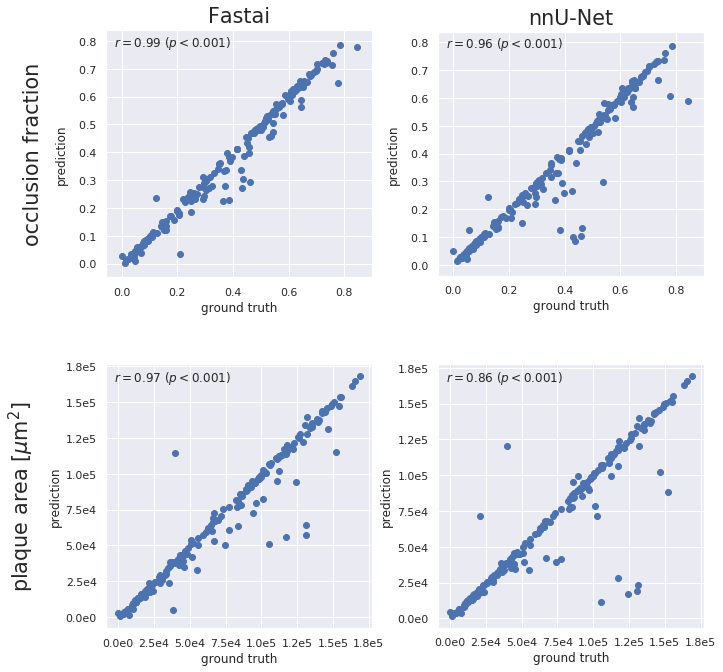

In [695]:
fig, axs = plt.subplots(2,2, figsize=(10,10), subplot_kw={'aspect': 1})
plt.setp(axs.flat, xlabel='ground truth', ylabel='prediction')

axs[0,0].scatter(fastai_of_gt, fastai_of_pred)
axs[0,0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '  {}'.format(str(x.round(1)))))

axs[0,1].scatter(nnunet2_of_gt, nnunet2_of_pred)
axs[0,1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '  {}'.format(str(x.round(1)))))

axs[1,0].scatter(fastai_pa_gt, fastai_pa_pred)
axs[1,0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:.1e}'.format(x).replace('+0','')))
axs[1,0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:.1e}'.format(x).replace('+0','')))

axs[1,1].scatter(nnunet2_pa_gt, nnunet2_pa_pred)

axs[1,1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:.1e}'.format(x).replace('+0','')))
axs[1,1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:.1e}'.format(x).replace('+0','')))


pad = 8

for ax, col in zip(axs[0], ['Fastai', 'nnU-Net']):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='xx-large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], ['occlusion fraction', 'plaque area [$\mu$m$^2$]']):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='xx-large', ha='right', va='center', rotation=90) 
fig.tight_layout()


axs[0,0].text(0.25, 0.95,'$r='+ str(round(focr,2)) + '$ $(p<0.001)$', horizontalalignment='center', verticalalignment='center', transform=axs[0,0].transAxes)
axs[0,1].text(0.25, 0.95,'$r='+ str(round(nocr,2)) + '$ $(p<0.001)$', horizontalalignment='center', verticalalignment='center', transform=axs[0,1].transAxes)
axs[1,0].text(0.25, 0.95,'$r='+ str(round(fpcr,2)) + '$ $(p<0.001)$', horizontalalignment='center', verticalalignment='center', transform=axs[1,0].transAxes)
axs[1,1].text(0.25, 0.95,'$r='+ str(round(npcr,2)) + '$ $(p<0.001)$', horizontalalignment='center', verticalalignment='center', transform=axs[1,1].transAxes)

# axs[0,0].text(0.15, 0.8,'$p<0.001$', horizontalalignment='center', verticalalignment='center', transform=axs[0,0].transAxes)
# axs[0,1].text(0.15, 0.8,'$p<0.001$', horizontalalignment='center', verticalalignment='center', transform=axs[0,1].transAxes)
# axs[1,0].text(0.15, 0.8,'$p<0.001$', horizontalalignment='center', verticalalignment='center', transform=axs[1,0].transAxes)
# axs[1,1].text(0.15, 0.8,'$p<0.001$', horizontalalignment='center', verticalalignment='center', transform=axs[1,1].transAxes)


plt.savefig('fig.png', bbox_inches='tight')
plt.show()

Next, we compute paired two tailed t-test, to assess whether mean difference between human and ground truth are significant.

Now, we compute the correlation between difference between prediction on ground truth with the accuracy.

In [43]:
f_of_d_corr = np.corrcoef(df[df['model_name']=='fastai']['accuracy'], abs(df[df['model_name']=='fastai']['occlusion_fraction_diff']))[0,1].round(2)
n_of_d_corr = np.corrcoef(df[df['model_name']=='nnunet2']['accuracy'], abs(df[df['model_name']=='nnunet2']['occlusion_fraction_diff']))[0,1].round(2)
f_pa_d_corr = np.corrcoef(df[df['model_name']=='fastai']['accuracy'], abs(df[df['model_name']=='fastai']['plaque_area_diff']))[0,1].round(2)
n_pa_d_corr = np.corrcoef(df[df['model_name']=='nnunet2']['accuracy'], abs(df[df['model_name']=='nnunet2']['plaque_area_diff']))[0,1].round(2)

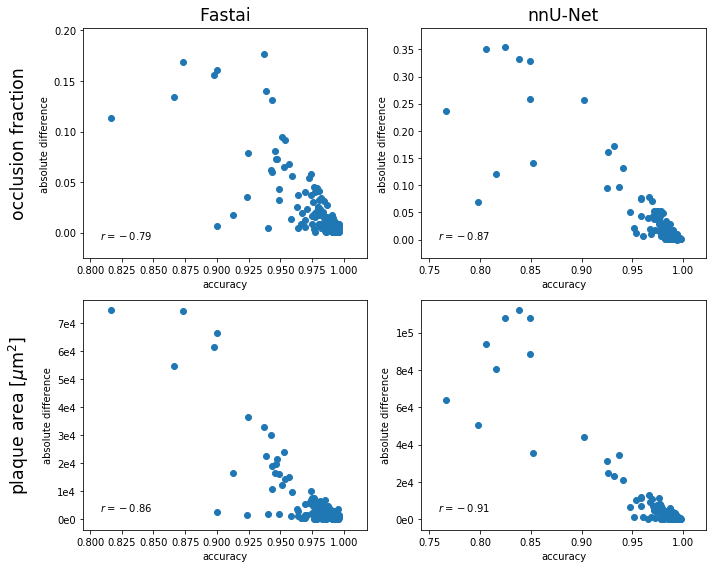

In [45]:
fig, axs = plt.subplots(2,2, figsize=(10,8))
plt.setp(axs.flat, xlabel='accuracy', ylabel='absolute difference')

axs[0,0].scatter(df[df['model_name']=='fastai']['accuracy'].values, abs(df[df['model_name']=='fastai']['occlusion_fraction_diff'].values))
axs[0,1].scatter(df[df['model_name']=='nnunet2']['accuracy'].values, abs(df[df['model_name']=='nnunet2']['occlusion_fraction_diff'].values))

axs[1,0].scatter(df[df['model_name']=='fastai']['accuracy'].values, abs(df[df['model_name']=='fastai']['plaque_area_diff'].values))
axs[1,0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:.0e}'.format(x).replace('+0','')))

axs[1,1].scatter(df[df['model_name']=='nnunet2']['accuracy'].values, abs(df[df['model_name']=='nnunet2']['plaque_area_diff'].values))
axs[1,1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:.0e}'.format(x).replace('+0','')))



pad = 8

for ax, col in zip(axs[0], ['Fastai', 'nnU-Net']):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='xx-large', ha='center', va='baseline')

for ax, row in zip(axs[:,0], ['occlusion fraction', 'plaque area [$\mu$m$^2$]']):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='xx-large', ha='right', va='center', rotation=90) 
fig.tight_layout()


axs[0,0].text(0.15, 0.1,'$r='+ str(f_of_d_corr) + '$', horizontalalignment='center', verticalalignment='center', transform=axs[0,0].transAxes)
axs[0,1].text(0.15, 0.1,'$r='+ str(n_of_d_corr) + '$', horizontalalignment='center', verticalalignment='center', transform=axs[0,1].transAxes)
axs[1,0].text(0.15, 0.1,'$r='+ str(f_pa_d_corr) + '$', horizontalalignment='center', verticalalignment='center', transform=axs[1,0].transAxes)
axs[1,1].text(0.15, 0.1,'$r='+ str(n_pa_d_corr) + '$', horizontalalignment='center', verticalalignment='center', transform=axs[1,1].transAxes)


plt.savefig('/fig.png', bbox_inches='tight')
plt.show()

## Timings

In [95]:
timings = pd.read_csv('/timings.csv', delimiter=';')
timings['time_sec'] = timings.time.str.split(':').apply(lambda x: int(x[0])*60 + int(x[1]))

print(timings.time_sec.mean()*1089/3600)

print(timings.time_sec.mean()/60, timings.time_sec.mean() - int(timings.time_sec.mean()/60)*60)

print(timings.time_sec.std()/60, timings.time_sec.std() - int(timings.time_sec.std()/60)*60)

Average time for a segmentation 11:49 +/- 3:10

## Easy predictions over-represented?

In [294]:
dff = df[df['model_name']=='fastai']
dfn = df[df['model_name']=='nnunet2']

In [295]:
dff[['exp_year', 'exp_mouse', 'exp_ot']] = dff['id'].str.replace('ID','').str.replace('__','_').str.split('_', expand=True).iloc[:, :3]
dfn[['exp_year', 'exp_mouse', 'exp_ot']] = dfn['id'].str.replace('ID','').str.replace('__','_').str.split('_', expand=True).iloc[:, :3]

In [296]:
dffg = dff.groupby(['exp_mouse']).mean()
dfng = dfn.groupby(['exp_mouse']).mean()

(0.9925427242236186, 3.475744881692971e-38)

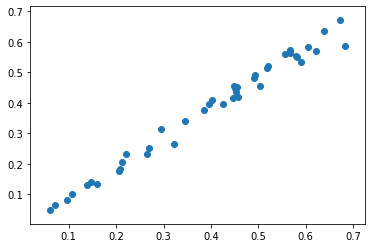

In [285]:
plt.scatter(dffg.gt_occlusion_fraction, dffg.pred_occlusion_fraction)
pearsonr(dffg.gt_occlusion_fraction, dffg.pred_occlusion_fraction)

(0.9787623510996142, 3.77631112833727e-29)

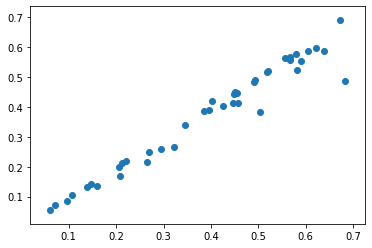

In [288]:
plt.scatter(dfng.gt_occlusion_fraction, dfng.pred_occlusion_fraction)
pearsonr(dfng.gt_occlusion_fraction, dfng.pred_occlusion_fraction)

In [305]:
for d, m, n in zip([dff, dff, dfn], ['gt','fastai', 'nnunet'], ['gt', 'pred', 'pred']):
    wg_std = d.groupby(['exp_mouse']).std()[f'{n}_occlusion_fraction'].mean()
    bt_std = d.groupby(['exp_mouse']).mean()[f'{n}_occlusion_fraction'].std()
    print(f'{m}: average within group std {wg_std} -- between group std {bt_std}')

gt: average within group std 0.1165211776199134 -- between group std 0.18116856148935015
fastai: average within group std 0.12196083032220272 -- between group std 0.1773235197894304
nnunet: average within group std 0.11784928458906771 -- between group std 0.17467258364062424


In [306]:
for d, m in zip([dff, dfn], ['fastai', 'nnunet']):
    wg_std = d.groupby(['exp_mouse']).std()[f'occlusion_fraction_diff'].mean()
    bt_std = d.groupby(['exp_mouse']).mean()[f'occlusion_fraction_diff'].std()
    print(f'{m}: average within group std {wg_std} -- between group std {bt_std}')

fastai: average within group std 0.021046199394544288 -- between group std 0.022224333085347714
nnunet: average within group std 0.02120915403212658 -- between group std 0.037233535996721245


## Bootstrapping Analysis

In [351]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

In [596]:
# first percentage difference 
df['perc_diff_of'] = (df['gt_occlusion_fraction']-df['pred_occlusion_fraction'])/df['gt_occlusion_fraction']
df['perc_diff_pa'] = (df['gt_plaque_area_um2']-df['pred_plaque_area_um2'])/df['gt_plaque_area_um2']

### Check plain differences

In [457]:
d = df.copy()
d[['exp_year', 'exp_mouse', 'exp_ot']] = d['id'].str.replace('ID','').str.replace('__','_').str.split('_', expand=True).iloc[:, :3]
d = d.groupby(['exp_mouse', 'model_name']).mean()
d = d.reset_index()
dff = d[d['model_name']=='fastai']
dfn = d[d['model_name']=='nnunet2']

In [458]:
for m in ['fastai', 'nnunet2']:
    for n in ['occlusion_fraction', 'plaque_area']:
        print(f'{m} -- mean in diff_{n}:')
        print('\t', bs.bootstrap(d[d['model_name']==m][f'{n}_diff'].values, stat_func=bs_stats.mean))

fastai -- mean in diff_occlusion_fraction:
	 0.016413557085749115    (0.00952692775702407, 0.022661308383196153)
fastai -- mean in diff_plaque_area:
	 2928.2346005904424    (1357.5595357940383, 4262.61254074498)
nnunet2 -- mean in diff_occlusion_fraction:
	 0.02138512816832068    (0.008939869563698292, 0.031047259329393)
nnunet2 -- mean in diff_plaque_area:
	 3152.843052921301    (456.8878264626601, 5333.286480567367)


### Check percentage differences
Note: need to exclude one record with 0 plaque in gt

In [441]:
# want to test how it looks in terms of percentages 
t = df.copy()
t[['exp_year', 'exp_mouse', 'exp_ot']] = t['id'].str.replace('ID','').str.replace('__','_').str.split('_', expand=True).iloc[:, :3]
t = t[t['gt_occlusion_fraction']!=0.0]
t = t.groupby(['exp_mouse', 'model_name']).mean()
t = t.reset_index()

In [453]:
print("NOTE: This includes some data exclusion (1 image) to avoide inf in percent difference.")
for m in ['fastai', 'nnunet2']:
    for n in ['of', 'pa']:
        print(f'{m} -- mean in perc_diff_{n}:')
        print('\t', bs.bootstrap(t[t['model_name']==m][f'perc_diff_{n}'].values, stat_func=bs_stats.mean))

NOTE: This includes some data exclusion (1 image) to avoide inf in percent difference.
fastai -- mean in perc_diff_of:
	 0.06400916951726174    (0.04174565244538769, 0.08619075099975657)
fastai -- mean in perc_diff_pa:
	 0.06547807092699776    (0.04095368145727117, 0.08953946684652137)
nnunet2 -- mean in perc_diff_of:
	 0.05810551010577434    (0.03225131216685449, 0.08359850424710419)
nnunet2 -- mean in perc_diff_pa:
	 0.04837203336686515    (0.017915559354289706, 0.08081201188512242)


In [456]:
print("NOTE: This includes some data exclusion (1 image) to avoide inf in percent difference.")
print("!! --- also check if plain differences are substantially different than in case when leaving zero plaque images in.")
for m in ['fastai', 'nnunet2']:
    for n in ['occlusion_fraction', 'plaque_area']:
        print(f'{m} -- mean in diff_{n}:')
        print('\t', bs.bootstrap(t[t['model_name']==m][f'{n}_diff'].values, stat_func=bs_stats.mean))

NOTE: This includes some data exclusion (1 image) to avoide inf in percent difference.
!! --- also check if plain differences are substantially different than in case when leaving zero plaque images in.
fastai -- mean in diff_occlusion_fraction:
	 0.016579427857776777    (0.009679063254339006, 0.02282243464277859)
fastai -- mean in diff_plaque_area:
	 2945.4365066803293    (1441.3377291880252, 4295.159484947052)
nnunet2 -- mean in diff_occlusion_fraction:
	 0.02162307645165677    (0.009369085977171489, 0.031180949347607637)
nnunet2 -- mean in diff_plaque_area:
	 3175.7593314790756    (526.0866680052959, 5329.107296576027)


### Check x% under y% difference on image level, based on Phillip's comment

In [752]:
df[df['model_name']=='nnunet2']['perc_diff_of'].quantile(.25)

-0.0018679294903714808

### Make Plots

In [495]:
import seaborn as sns

In [599]:
num_iterations = 10000
metrics_dict = {}
models = ['fastai', 'nnunet2']
variables = ['perc_diff_of', 'perc_diff_pa']
results = {}

for m in models: 
    results[m] = {}
    for v in variables:
        results[m][v] = {}
        dist = bs.bootstrap(t[t['model_name']==m][v].values, stat_func=bs_stats.mean, return_distribution=True, num_iterations=num_iterations)
        conf = bs.bootstrap(t[t['model_name']==m][v].values, stat_func=bs_stats.mean, return_distribution=False, num_iterations=num_iterations)
        results[m][v]['data'] = t[t['model_name']==m][v].values
        results[m][v]['dist'] = dist
        results[m][v]['conf'] = conf

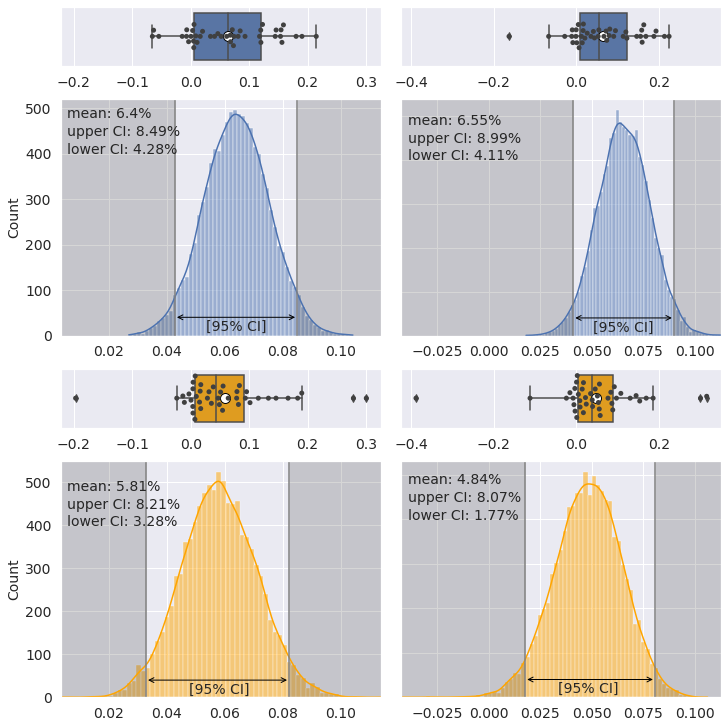

In [765]:
fig = plt.figure(figsize=(10,10), constrained_layout=True)
widths = [5, 5]
heights = [1, 4, 1, 4]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths, height_ratios=heights)
axs = []

for row in range(len(heights)):
    ax = []
    for col in range(len(widths)):
        ax.append(fig.add_subplot(spec[row, col]))
    axs.append(ax)

    
# general properties
meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black", "markersize":"10"}
alpha = 0.2
fontsize=14
# set up
sns.set_color_codes()
models = ['fastai', 'nnunet2']
variables = ['perc_diff_of', 'perc_diff_pa']
c = {0: 'b', 1: 'orange'}

# find limits
blims, hlims = np.ones((2,2,2)), np.ones((2,2,2))

for i,m in enumerate(models):
    for j,v in enumerate(variables):
        _min, _max = np.min(results[m][v]['data']), np.max(results[m][v]['data'])
        offset = (_max - _min)*0.05
        blims[i,j,:] = _min-offset, _max+offset
        hlims[i,j,:] = np.min(results[m][v]['dist']), np.max(results[m][v]['dist'])
        
for l in [blims, hlims]:
    for j in range(len(variables)):
        l[:,j,0] = np.min(l, axis=0)[j,0]
        l[:,j,1] = np.max(l, axis=0)[j,1]

#### Record 


for i, m in enumerate(models):
    for j, v in enumerate(variables):
        bax = axs[i*2][j] # boxplot axes
        hax = axs[i*2+1][j] # histo axes
        d = results[m][v] # data dict
        # Boxplot component        
        sns.boxplot(x=d['data'], showmeans=True, meanprops=meanprops, ax=bax, color=c[i])
        sns.swarmplot(x=d['data'], color=".25", ax=bax)
        bax.set_xlim(blims[i,j,0], blims[i,j,1])
        # Histogram of bootstrap
        sns.histplot(d['dist'], kde=True, ax=hax, color=c[i])
        mean, lb, ub = d['conf'].value, d['conf'].lower_bound, d['conf'].upper_bound
#         hax.axvline(mean, color='black')
        hax.axvline(lb, color='grey')
        hax.axvline(ub, color='grey')
        hax.margins(0,0.05)
        hax.set_xlim(hlims[i,j,0], hlims[i,j,1])
        hax.axvspan(hax.get_xlim()[0], lb, facecolor='0.2', alpha=alpha)
        hax.axvspan(hax.get_xlim()[1], ub, facecolor='0.2', alpha=alpha)
        
        
        hax.tick_params(axis='x', labelsize=14)
        bax.tick_params(axis='x', labelsize=14)
        hax.tick_params(axis='y', labelsize=14)
        bax.tick_params(axis='y', labelsize=14)
        
        hax.yaxis.label.set_fontsize(fontsize)
        
        if j==1:
            hax.set_ylabel('')
            hax.set_yticklabels([])
            hax.tick_params(axis='y')
        
        # ax.annotate('lower bound', xy=(lb, 25), ha='right')
        hax.annotate('', xy=(lb, 40), xytext=(ub, 40), arrowprops=dict(arrowstyle="<->", ls='-', color='black'))
        hax.annotate('[95% CI]', xy=(mean,10), ha='center', fontsize=fontsize)
        xpos = hax.get_xlim()[0] + (hax.get_xlim()[1] - hax.get_xlim()[0])*0.02
        hax.annotate(f'mean: {round(mean*100,2)}%', xy=(xpos,480), fontsize=fontsize)
        hax.annotate(f'upper CI: {round(ub*100,2)}%', xy=(xpos,440), fontsize=fontsize)
        hax.annotate(f'lower CI: {round(lb*100,2)}%', xy=(xpos,400), fontsize=fontsize)

#         hax.legend([],['test', 'test', 'test'], loc='upper left')



fig.savefig('../output/of_pa_bootstrap.svg', format='svg', dpi=1200)        
fig.savefig('../output/of_pa_bootstrap.png', format='png', dpi=1200)
fig.show()

### Correlations replot

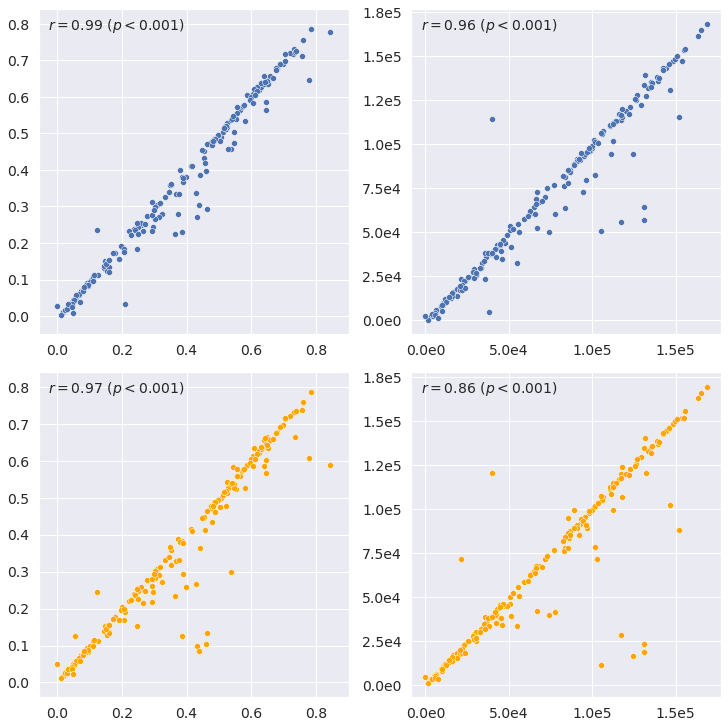

In [767]:
fig, axs = plt.subplots(2,2, figsize=(10,10), constrained_layout=True)

models=['fastai', 'nnunet2']
variables = [('gt_occlusion_fraction', 'pred_occlusion_fraction'), ('gt_plaque_area_um2', 'pred_plaque_area_um2')]
c = {0: 'b', 1: 'orange'}

for i, m in enumerate(models):
    for j, v in enumerate(variables):
        sns.scatterplot(x=df[df['model_name']==m][v[0]], y=df[df['model_name']==m][v[1]], ax=axs[i,j], color=c[i])
        axs[i,j].set_ylabel('')
        axs[i,j].set_xlabel('')
        axs[i,j].tick_params(axis='x', labelsize=14)
        axs[i,j].tick_params(axis='y', labelsize=14)
        
        if j==1:
            
            axs[i,j].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:.1e}'.format(x).replace('+0','')))
            axs[i,j].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:.1e}'.format(x).replace('+0','')))


axs[0,0].text(0.25, 0.95,'$r='+ str(round(focr,2)) + '$ $(p<0.001)$', horizontalalignment='center', verticalalignment='center', transform=axs[0,0].transAxes, fontsize=14)
axs[0,1].text(0.25, 0.95,'$r='+ str(round(nocr,2)) + '$ $(p<0.001)$', horizontalalignment='center', verticalalignment='center', transform=axs[0,1].transAxes, fontsize=14)
axs[1,0].text(0.25, 0.95,'$r='+ str(round(fpcr,2)) + '$ $(p<0.001)$', horizontalalignment='center', verticalalignment='center', transform=axs[1,0].transAxes, fontsize=14)
axs[1,1].text(0.25, 0.95,'$r='+ str(round(npcr,2)) + '$ $(p<0.001)$', horizontalalignment='center', verticalalignment='center', transform=axs[1,1].transAxes, fontsize=14)
        
fig.savefig('../output/of_pa_correlation.svg', format='svg', dpi=1200)
fig.savefig('../output/of_pa_correlation.png', format='png', dpi=600)
fig.show()